In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np

In [44]:
import importlib
importlib.reload(portfolio)

<module 'portfolio' from '/home/prohb125/walkforwardTrader/portfolio.py'>

In [2]:
def getUniqueModels(allModels):
    ##MUST PASS IN MODEL ENTITY
    ##GETS BEST MODEL FOR EACH INPUT SERIES
    sequences = {} 
    for modelEntity in allModels:
        model = modelEntity["model"]
        thisSeq = str(model.inputSeries.describe())
        if thisSeq not in sequences:
            sequences[thisSeq] = []
        sequences[thisSeq].append({
            "model":model,
            "info":modelEntity
        })
    modelsToReturn = []
    for seq in sequences:
        bestModel = None
        for modelInfo in sequences[seq]:
            if bestModel is None:
                bestModel = modelInfo
            else:
                if bestModel["info"]["STABILITY"] < modelInfo["info"]["STABILITY"]:
                    bestModel = modelInfo
        modelsToReturn.append(bestModel["model"])
    return modelsToReturn

In [6]:
import portfolio
import dataAck
import warnings
import numpy as np
warnings.filterwarnings("ignore")
tickerToTrade = "VO"
allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
for modelEntity in allModels:
    model = modelEntity["model"]
    print(model.describe())

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)


In [7]:
uniqueModels = getUniqueModels(allModels)
for model in uniqueModels:
    print(model.describe())

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)


# VIEW CORRELATION AND COVARIANCE

In [8]:
def generateAllReturns(allModels, joinedData):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, factorReturn, predictions =  mod.makePredictions(joinedData)
        algoReturn.columns = [str(mod.describe())]
        predictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = predictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(predictions)
    return aggregateReturns, aggregatePredictions

In [55]:
tickersRequired = []
tickersTraded = []
for mod in uniqueModels:
    
    print(mod.describe())
    if mod.inputSeries.targetTicker not in tickersRequired:
        tickersRequired.append(mod.inputSeries.targetTicker)
    if mod.inputSeries.series.ticker not in tickersRequired:
        tickersRequired.append(mod.inputSeries.series.ticker)
    if mod.inputSeries.targetTicker not in tickersTraded:
        tickersTraded.append(mod.inputSeries.targetTicker)
    

pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
modelReturns, modelPredictions = generateAllReturns(uniqueModels, joinedData)

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)
TIP
VO
SHY
IWF
XLV
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
THREAD  1 PROGRESS: 0.6521739130434783
THREAD  2 PROGRESS: 0.6521739130434783
THREAD  0 PROGRESS: 0.6521739130434783
THREAD  6 PROGRESS: 0.6521739130434783
THREAD  4 PROGRESS: 0.6521739130434783
THREAD  3 PROGRESS: 0.6521739130434783
THREAD  5 PROGRESS: 0.6521739130434783
THREAD  9 PROGRESS: 0.6521739130434783
THREAD  10 PROGRESS: 0.6521739130434783
THREAD  12 PROGRESS: 0.6521739130434783
THREAD  7 PROGRESS: 0.6521739130434783
THREAD  8 PROGRESS: 0.6521739130434783
THREAD  11 PROGRESS: 0.6521739130434783
THREAD  15 PROGRESS: 0.6521739130434783
THREAD  13 PROGRESS: 0.6521739130434783
THREAD  14 PROGRESS: 0.6521739130434783
THREAD  18 PROGRESS: 0.6521739130434783
THREAD  16 PROGRESS: 0

In [56]:
modelReturns

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)"
2006-10-17,0.000198,-0.000000,0.000397,NaN,NaN
2006-10-18,-0.001509,-0.001509,-0.003019,NaN,NaN
2006-10-19,0.003920,-0.000000,0.005227,NaN,NaN
2006-10-20,-0.004140,0.000000,-0.004140,NaN,NaN
2006-10-23,-0.003172,0.001586,-0.003172,NaN,NaN
2006-10-24,-0.001423,0.001423,-0.002845,NaN,NaN
2006-10-25,0.000000,0.000000,-0.008354,NaN,NaN
2006-10-26,-0.000000,-0.000000,0.009692,NaN,NaN
2006-10-27,0.000000,-0.000947,0.000000,0.000947,NaN
2006-10-30,-0.000000,-0.000000,-0.000000,-0.001733,NaN


In [57]:
modelPredictions

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)"
2006-10-17,-0.25,0.0,-0.5,NaN,NaN
2006-10-18,-0.50,-0.5,-1.0,NaN,NaN
2006-10-19,-0.75,0.0,-1.0,NaN,NaN
2006-10-20,-1.00,0.0,-1.0,NaN,NaN
2006-10-23,-1.00,0.5,-1.0,NaN,NaN
2006-10-24,-0.50,0.5,-1.0,NaN,NaN
2006-10-25,0.00,0.0,-1.0,NaN,NaN
2006-10-26,0.00,0.0,-1.0,NaN,NaN
2006-10-27,0.00,-0.5,0.0,0.5,NaN
2006-10-30,0.00,0.0,0.0,1.0,NaN


In [58]:
modelReturnsWithFactor = modelReturns.join(dataAck.getDailyFactorReturn(tickerToTrade, joinedData))

In [59]:
def visualizeModels(modelReturns):
    from string import ascii_letters
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from IPython.display import display

    sns.set(style="white")


    # Compute the correlation matrix
    corr = modelReturns.corr()
    display(corr)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    from matplotlib.colors import ListedColormap

    # construct cmap
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    cmap = ListedColormap(sns.color_palette(flatui).as_hex())
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    sns.set(style="white")
    
    # Compute the covariance matrix
    cov = modelReturns.cov()
    display(cov)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(cov, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(cov, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",Factor Return
"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)",1.000000,0.124953,0.350697,0.137474,0.052138,0.300535
"((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)",0.124953,1.000000,0.177608,-0.040939,0.122364,0.478116
"((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)",0.350697,0.177608,1.000000,0.040528,0.159648,0.404033
"((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)",0.137474,-0.040939,0.040528,1.000000,0.137774,0.018946
"((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",0.052138,0.122364,0.159648,0.137774,1.000000,0.321710
Factor Return,0.300535,0.478116,0.404033,0.018946,0.321710,1.000000


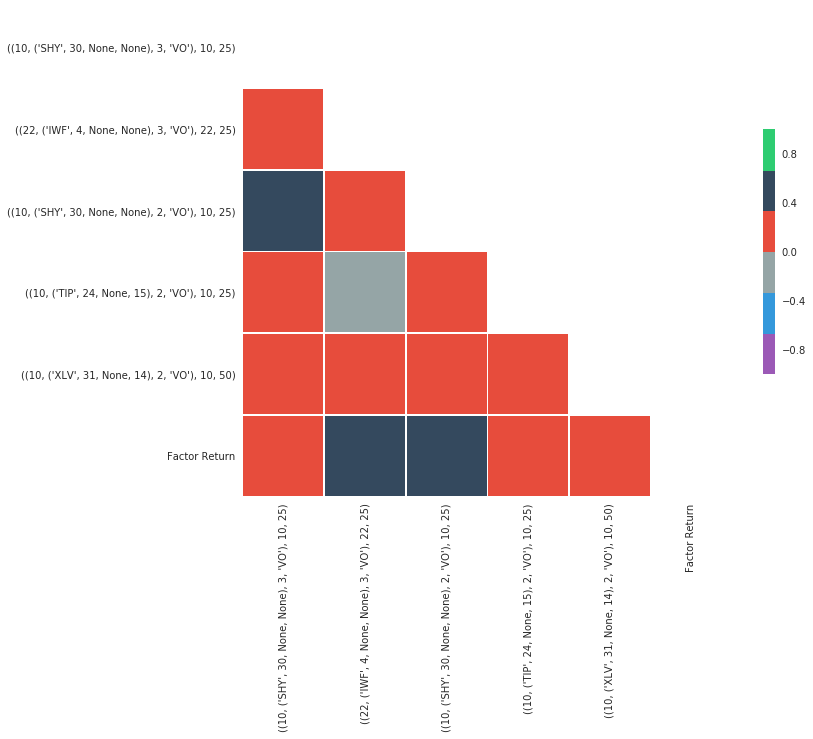

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",Factor Return
"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)",0.000069,0.000009,0.000032,0.000013,0.000005,0.000035
"((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)",0.000009,0.000073,0.000017,-0.000004,0.000012,0.000058
"((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)",0.000032,0.000017,0.000122,0.000005,0.000021,0.000064
"((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)",0.000013,-0.000004,0.000005,0.000135,0.000019,0.000003
"((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",0.000005,0.000012,0.000021,0.000019,0.000141,0.000055
Factor Return,0.000035,0.000058,0.000064,0.000003,0.000055,0.000202


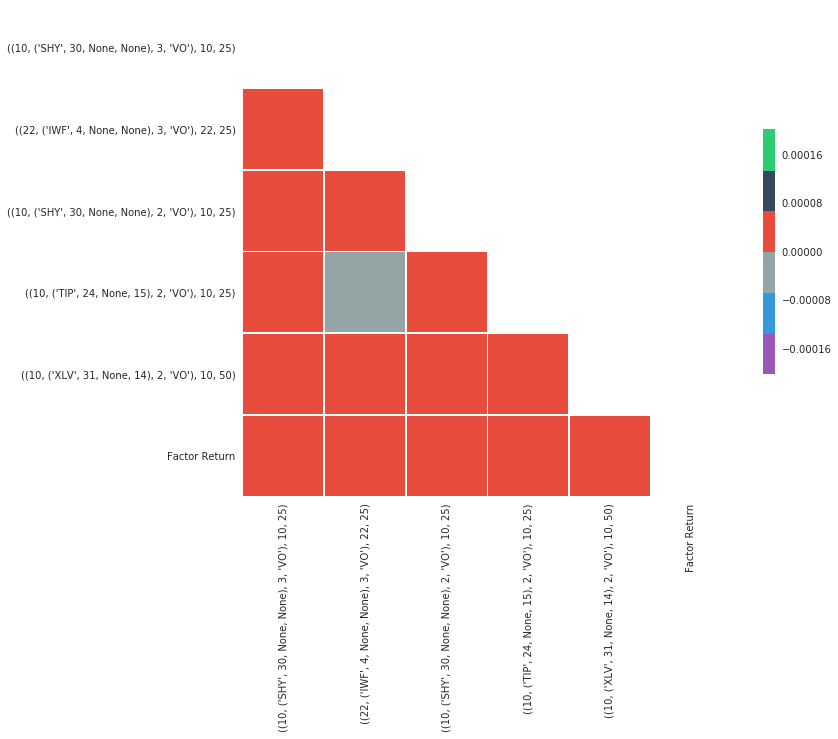

In [60]:
%matplotlib inline
visualizeModels(modelReturnsWithFactor)

# STORE PAST MODEL PREDICTIONS

In [62]:
def storePastPredictions(allModels, modelPredictions):
    ##THESE ARE SUMMED PREDICTIONS...DIFFERENT THAN PREDICTIONS MADE DAILY
    lastDayUsedPredictions = modelPredictions.dropna()
    for i in range(len(lastDayUsedPredictions.columns)):
        thisModel = allModels[i]
        print(thisModel.describe())
        thisDF = lastDayUsedPredictions[[lastDayUsedPredictions.columns[i]]]
        predictionsToStore = []
        for j in range(len(thisDF.values)):
#             print(thisDF.index[i], thisDF.values[i][0])
            predictionsToStore.append(portfolio.storeAggregateModelPrediction(thisModel, thisDF.values[j][0], thisDF.index[j], shouldReturn=True))
        portfolio.storeManyItems(predictionsToStore)
            

In [63]:
storePastPredictions(uniqueModels, modelPredictions)

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)


# STORE MODELS AS PORTFOLIO

In [47]:
def storePortfolio(models, description, benchmark):
    allHashes = []
    for model in models:
        organismHash = hashlib.sha224(str(model.describe()).encode('utf-8')).hexdigest()
        allHashes.append(organismHash)
    
    allHashes.sort()
    portfolioHash = hashlib.sha224(str(allHashes).encode('utf-8')).hexdigest()
    print("PORTFOLIO HASH:", portfolioHash)
    for hashing in allHashes:
        print(hashing)
        
    
        ##UPLOAD ORGANISM OBJECT
        while True:
            try:
                toUpload = {
                    "portfolio":portfolioHash,
                    "model":hashing
                }
                datastoreClient = datastore.Client('money-maker-1236')
                #HASH DIGEST
                key = datastoreClient.key(params.portfolioDB, hashlib.sha224(str(hashing + portfolioHash).encode('utf-8')).hexdigest()) #NEED TO HASH TO ENSURE UNDER COUNT
                organismToStore = datastore.Entity(key=key)
                organismToStore.update(toUpload)
                datastoreClient.put(organismToStore)
                break
            except:
                print("UPLOAD ERROR:", str(sys.exc_info()))
                time.sleep(10)
    
    ##STORE PORTFOLIO OBJECT
    while True:
        try:
            toUpload = {
                "description":description,
                "benchmark":benchmark
            }
            datastoreClient = datastore.Client('money-maker-1236')
            #HASH DIGEST
            key = datastoreClient.key(params.portfolioLookup, portfolioHash) #NEED TO HASH TO ENSURE UNDER COUNT
            organismToStore = datastore.Entity(key=key)
            organismToStore.update(toUpload)
            datastoreClient.put(organismToStore)
            break
        except:
            print("UPLOAD ERROR:", str(sys.exc_info()))
            time.sleep(10)

In [48]:
storePortfolio(uniqueModels, description=tickerToTrade + " 8-13-17", benchmark=tickerToTrade)

PORTFOLIO HASH: 7d372f0c7053ce8035616e2ba82f33de0cfebccbd78e4e3798f0c18f
0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3
11912f289e86b30f1af1b7272e773732dd099e3069cdf79f1c2ba47e
2c69141675447782e2a74036a7cbd8fb5fc08476cebf557bd6e787a6
341fe3e8eb88c9fbdd779c6c8727762f99fc1043383dd8242da044e9
78afec28d6c4e55102b09d8b6b179a3508e2b03fb46d2e8858c14fdc


In [49]:
def getPortfolios():
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.portfolioLookup)
            retrievedPortfolios = [{
                "key":item.key.name,
                "description":item["description"],
                "benchmark":item["benchmark"]
            } for item in list(query.fetch())]

            return retrievedPortfolios
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [50]:
portfolios = getPortfolios()
print(portfolios)

[{'key': '7d372f0c7053ce8035616e2ba82f33de0cfebccbd78e4e3798f0c18f', 'description': 'VO 8-13-17', 'benchmark': 'VO'}]


In [51]:
def getPortfolioModels(portfolioKey):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.portfolioDB)
            query.add_filter('portfolio', '=', portfolioKey)
            
            retrievedModels = [item["model"] for item in list(query.fetch())]

            return retrievedModels
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [52]:
for item in portfolios:
    print(item)
    print(getPortfolioModels(item["key"]))

{'key': '7d372f0c7053ce8035616e2ba82f33de0cfebccbd78e4e3798f0c18f', 'description': 'VO 8-13-17', 'benchmark': 'VO'}
['2c69141675447782e2a74036a7cbd8fb5fc08476cebf557bd6e787a6', '0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3', '11912f289e86b30f1af1b7272e773732dd099e3069cdf79f1c2ba47e', '78afec28d6c4e55102b09d8b6b179a3508e2b03fb46d2e8858c14fdc', '341fe3e8eb88c9fbdd779c6c8727762f99fc1043383dd8242da044e9']


In [53]:
def getModelsByKey(modelHashes):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            ##form keys
            keys = []
            for hashing in modelHashes:
                key = datastore_client.key(params.datastoreName, hashing)
                keys.append(key)
                
            retrievedModels = datastore_client.get_multi(keys)
            toReturn = []
            for source in retrievedModels:
                toReturn.append(pickle.loads(source["model"]))
            return toReturn
            
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [54]:
getModelsByKey(getPortfolioModels(item["key"]))